In [15]:
import pandas as pd
import plotly.express as px
from dash import Dash, html, dcc
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import detrend

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel('XN-Project Data.xlsx')

df['Worked Date'] = pd.to_datetime(df['Worked Date'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['Worked Date'])

In [3]:
df

,Customer Name,Project,Worked Date,Task or Ticket Title,Resource Name,Billable Hours,Hourly Billing Rate,Extended Price
0,Macroservice,Enhancements to Site Creation App and Scripts,2024-01-02,Consultant,GO,2.0,175.0,350.0
1,Macroservice,Enhancements to Site Creation App and Scripts,2024-01-03,Consultant,GO,4.0,175.0,700.0
2,Macroservice,Enhancements to Site Creation App and Scripts,2024-01-04,Consultant,GO,3.0,175.0,525.0
3,Macroservice,Enhancements to Site Creation App and Scripts,2024-01-16,Consultant,GO,4.0,175.0,700.0
4,Macroservice,Enhancements to Site Creation App and Scripts,2024-01-17,Consultant,GO,4.0,175.0,700.0
...,...,...,...,...,...,...,...,...
13683,WRS,City GP – Bitlocker Management,2020-10-14,WRS - City GP – Bitlocker Management,DG,1.5,150.0,225.0
13684,WRS,City GP – Bitlocker Management,2020-10-15,WRS - City GP – Bitlocker Management,DG,1.0,150.0,150.0
13685,WRS,City GP – Bitlocker Management,2020-10-15,WRS - City GP – Bitlocker Management,DG,1.0,150.0,150.0
13686,WRS,City GP – Bitlocker Management,2020-10-26,WRS - City GP – Bitlocker Management,DG,1.5,150.0,225.0


# Feature Engineering

### Sector

In [4]:
# Comprehensive categorization function for customer names
def detailed_customer_categorization(name):
    name_lower = name.lower()
    if any(word in name_lower for word in ['school', 'edu', 'sd', 'k12', 'douglas', 'capilano', 'cnc',
                                           'college', 'university', 'viu', 'nic', 'langara', 'nvit', 'emily', 'triumf', 'rru', 'regina school', 'saskatoon school', 'universityhill']):
        return 'Education Sector'
    elif any(word in name_lower for word in ['city', 'justice', 'police', 'transportation', 'richmond', 'surrey', 'saanich', 'state library', 'rdck', 'tol', 'regional', 'castlegar', 'langley', 'alberta', 'bc', 'maple ridge']):
        return 'Government/Municipality'
    elif any(word in name_lower for word in ['health', 'mental', 'pharmacy', 'cmha', 'cowichan women', 'lookout housing society']):
        return 'Health & Community Services'
    elif any(word in name_lower for word in ['microsoft', 'micro', 'ios', 'insight', 'secure', 'quickpass', 'steeves', 'okc', 'dtm', 'fx', 'pt', 'solaris', 'wenco']):
        return 'Technology & IT'
    elif any(word in name_lower for word in ['mining', 'paper', 'energy', 'maven', 'metrocan', 'hemlock', 'madison', 'macroservice',
                                             'changemark', 'mvc', 'soft', 'lehigh', 'metroc', 'taymor', 'eatless', 'bgo', 'dmcl', 'mag',
                                             'chocolate', 'winpak', 'soleil', 'faraway', 'rockies', 'naturalmart', 'iris', 'silver', 'plenary', 'old paper', 'great paper', 'catalyst']):
        return 'Commercial/Corporate'
    else:
        return 'Other'

# Apply this detailed categorization
df['Detailed Customer Category'] = df['Customer Name'].apply(detailed_customer_categorization)

# Display comprehensive customer category distribution
detailed_category_counts = df['Detailed Customer Category'].value_counts()
detailed_category_counts

Detailed Customer Category
Education Sector               3681
Commercial/Corporate           3054
Government/Municipality        2632
Other                          1721
Technology & IT                1453
Health & Community Services    1147
Name: count, dtype: int64

In [5]:
df['Month'] = df['Worked Date'].dt.month
df['Quarter'] = df['Worked Date'].dt.quarter
df['Day_of_Week'] = df['Worked Date'].dt.day_name()
df['Year'] = df['Worked Date'].dt.year

first_project = df.groupby('Customer Name')['Worked Date'].transform('min')
df['Days_Since_First_Project'] = (df['Worked Date'] - first_project).dt.days

project_counts = df.groupby('Customer Name')['Project'].nunique()
def customer_size(name):
    count = project_counts.get(name, 0)
    if count < 5:
        return 'Small'
    elif count <= 20:
        return 'Medium'
    else:
        return 'Large'
df['Customer_Size'] = df['Customer Name'].apply(customer_size)

df['Customer_Start_Year'] = first_project.dt.year

most_used_resource = df.groupby('Customer Name')['Resource Name'].agg(lambda x: x.value_counts().idxmax())
df['Top_Resource'] = df['Customer Name'].map(most_used_resource)

df['Total_Revenue'] = df.groupby('Customer Name')['Extended Price'].transform('sum')
df['Avg_Hourly_Rate'] = df.groupby('Customer Name')['Hourly Billing Rate'].transform('mean')
df['Avg_Project_Revenue'] = df.groupby(['Customer Name', 'Project'])['Extended Price'].transform('sum')

df['Tasks_Per_Project'] = df.groupby(['Customer Name', 'Project'])['Task or Ticket Title'].transform('count')
df = df.sort_values(['Customer Name', 'Worked Date'])
df['Days_Since_Last_Project'] = df.groupby('Customer Name')['Worked Date'].diff().dt.days.fillna(0)

def categorize_project(title):
    title_lower = title.lower()
    if 'enhancement' in title_lower:
        return 'Enhancement'
    elif 'support' in title_lower:
        return 'Support'
    elif 'implementation' in title_lower:
        return 'Implementation'
    else:
        return 'Other'
df['Project_Type'] = df['Task or Ticket Title'].apply(categorize_project)

# Autocorrelation

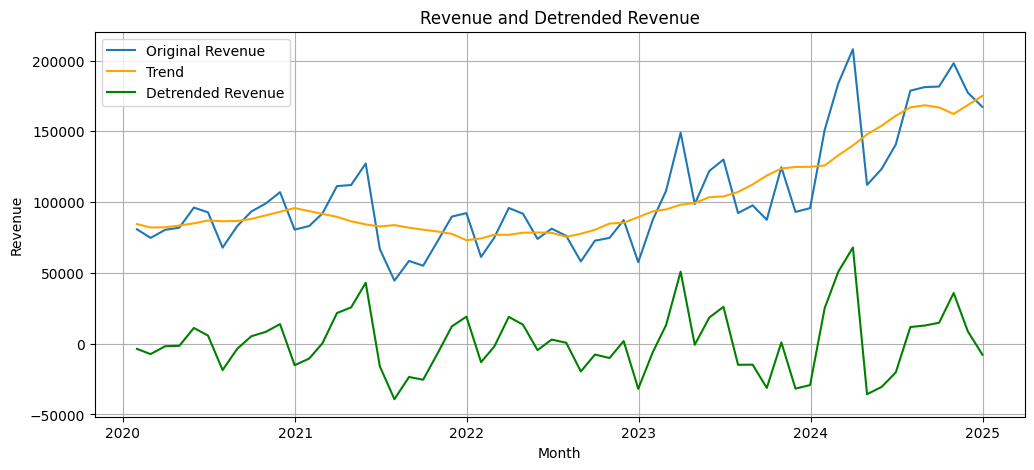

In [6]:
# Detrend revenue, rolling mean (12 month window)
# Detrended Revenue
monthly_rev = df.groupby(pd.Grouper(key='Worked Date', freq='M'))['Extended Price'].sum()
trend = monthly_rev.rolling(window=12, center=True, min_periods=1).mean()
detrended = monthly_rev - trend

plt.figure(figsize=(12,5))
plt.plot(monthly_rev.index, monthly_rev, label='Original Revenue')
plt.plot(trend.index, trend, label='Trend', color='orange')
plt.plot(detrended.index, detrended, label='Detrended Revenue', color='green')
plt.title('Revenue and Detrended Revenue')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.show()

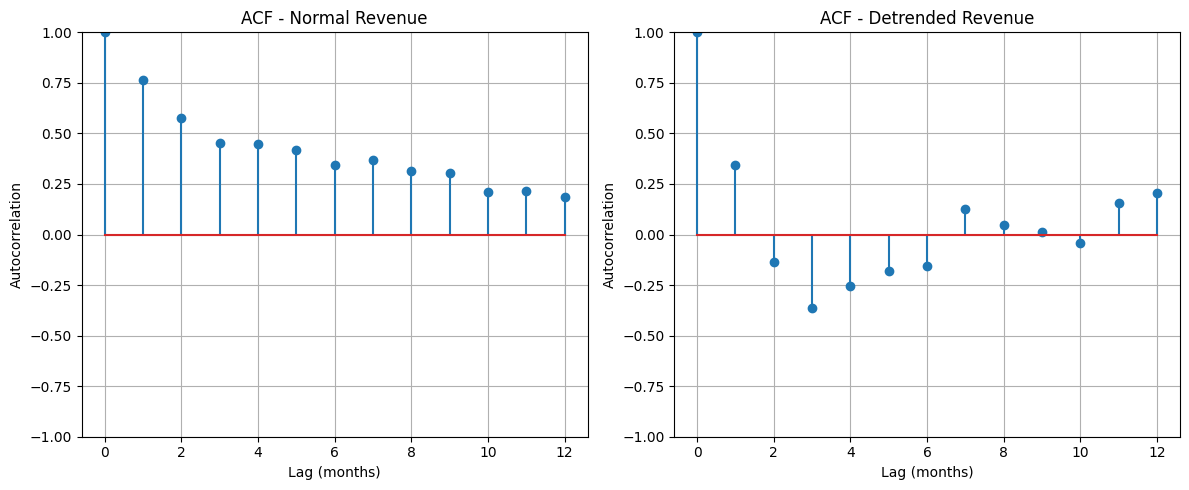

In [7]:
# ACF For all revenue detrended and non-detrended
monthly_rev = df.groupby(pd.Grouper(key='Worked Date', freq='ME'))['Extended Price'].sum()

trend = monthly_rev.rolling(window=12, center=True, min_periods=1).mean()

detrended = monthly_rev - trend

acf_normal = acf(monthly_rev.dropna(), nlags=12, fft=False)
acf_detrended = acf(detrended.dropna(), nlags=12, fft=False)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.stem(range(len(acf_normal)), acf_normal)
plt.title('ACF - Normal Revenue')
plt.xlabel('Lag (months)')
plt.ylabel('Autocorrelation')
plt.ylim(-1, 1)
plt.grid(True)

plt.subplot(1,2,2)
plt.stem(range(len(acf_detrended)), acf_detrended)
plt.title('ACF - Detrended Revenue')
plt.xlabel('Lag (months)')
plt.ylabel('Autocorrelation')
plt.ylim(-1, 1)
plt.grid(True)

plt.tight_layout()
plt.show()


In [8]:
def seasonality_score(series, lag=12):
    """
    Returns the autocorrelation at a given lag as a seasonality score.
    Higher values mean stronger seasonality.
    """
    series = series.dropna()
    if len(series) < lag + 1:
        return np.nan
    acf_vals = acf(series, nlags=lag, fft=False)
    return acf_vals[lag]  # autocorrelation at the seasonal lag

In [9]:
categorical_columns = ['Detailed Customer Category', 'Customer Name', 'Project', 'Resource Name']

results = []

for col in ['Detailed Customer Category', 'Customer_Size', 'Project_Type', 'Top_Resource']:
    for cat, group in df.groupby(col):
        monthly_rev = group.groupby(pd.Grouper(key='Worked Date', freq='M'))['Extended Price'].sum()
        score = seasonality_score(monthly_rev, lag=12)  # Corrected
        results.append({'Column': col, 'Category': cat, 'SeasonalityScore': score})

seasonality_df = pd.DataFrame(results)
seasonality_df = seasonality_df.sort_values('SeasonalityScore', ascending=False)
seasonality_df.head(10)

,Column,Category,SeasonalityScore
10,Project_Type,Support,0.353075
3,Detailed Customer Category,Health & Community Services,0.321305
24,Top_Resource,MA,0.256555
7,Customer_Size,Small,0.228341
4,Detailed Customer Category,Other,0.224911
15,Top_Resource,Contractor,0.207680
9,Project_Type,Other,0.194747
8,Project_Type,Implementation,0.154097
6,Customer_Size,Medium,0.114110
1,Detailed Customer Category,Education Sector,0.103950


In [10]:
target_column = 'Extended Price'
lag = 12 

categorical_features = [
    'Detailed Customer Category', 
    'Customer_Size', 
    'Top_Resource', 
    'Project_Type'
]

def seasonality_score(series, lag=12):
    series = series.dropna()
    if len(series) < lag + 1:
        return np.nan
    acf_vals = acf(series, nlags=lag, fft=False)
    return acf_vals[lag]

results = []

for feature in categorical_features:
    groups = df.groupby(feature)
    for category, group in groups:
        monthly_rev = group.groupby(pd.Grouper(key='Worked Date', freq='M'))[target_column].sum()
        monthly_rev_detrended = pd.Series(detrend(monthly_rev), index=monthly_rev.index)
        score = seasonality_score(monthly_rev_detrended, lag)
        results.append({
            'Feature': feature,
            'Category': category,
            'SeasonalityScore': score
        })

seasonality_df = pd.DataFrame(results)
seasonality_df = seasonality_df.sort_values('SeasonalityScore', ascending=False)
print(seasonality_df.head(20))


                       Feature                     Category  SeasonalityScore
7                Customer_Size                        Small          0.230594
3   Detailed Customer Category  Health & Community Services          0.203000
26                Project_Type                      Support          0.153042
20                Top_Resource                           KC          0.125361
25                Project_Type                        Other          0.098591
24                Project_Type               Implementation          0.095995
11                Top_Resource                        Bingo          0.095755
4   Detailed Customer Category                        Other          0.061158
21                Top_Resource                           MA          0.056395
12                Top_Resource                   Contractor          0.051806
1   Detailed Customer Category             Education Sector          0.020986
6                Customer_Size                       Medium     

# ACF 

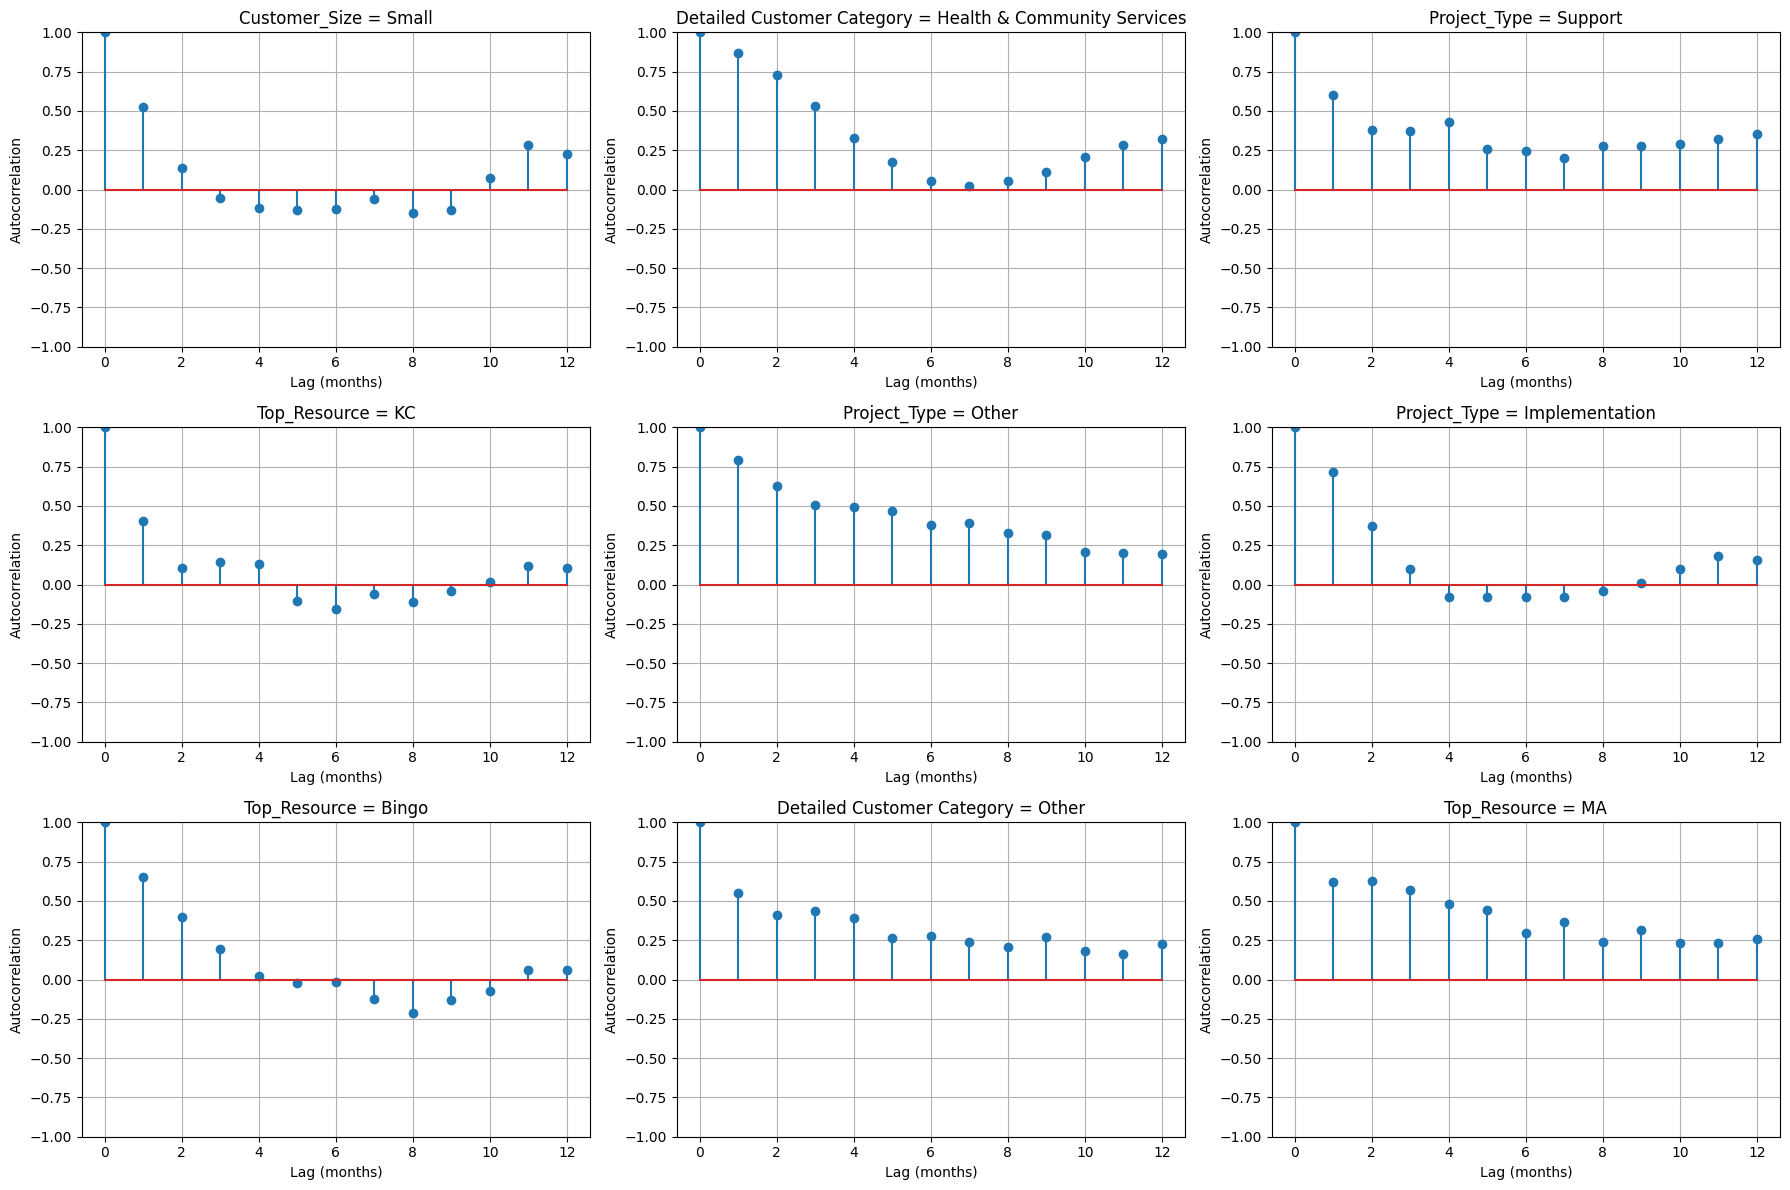

In [11]:
# Non-detrended ACF

top9 = seasonality_df.head(9)

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (i, row) in enumerate(top9.iterrows()):
    feature = row['Feature']
    category = row['Category']
    
    group = df[df[feature] == category]
    monthly_rev = group.groupby(pd.Grouper(key='Worked Date', freq='ME'))['Extended Price'].sum()

    acf_vals = acf(monthly_rev, nlags=12, fft=False)
    
    axes[idx].stem(range(len(acf_vals)), acf_vals)
    axes[idx].set_title(f'{feature} = {category}', fontsize=12)
    axes[idx].set_xlabel('Lag (months)')
    axes[idx].set_ylabel('Autocorrelation')
    axes[idx].set_ylim(-1, 1)
    axes[idx].grid(True)

plt.tight_layout()
plt.show()

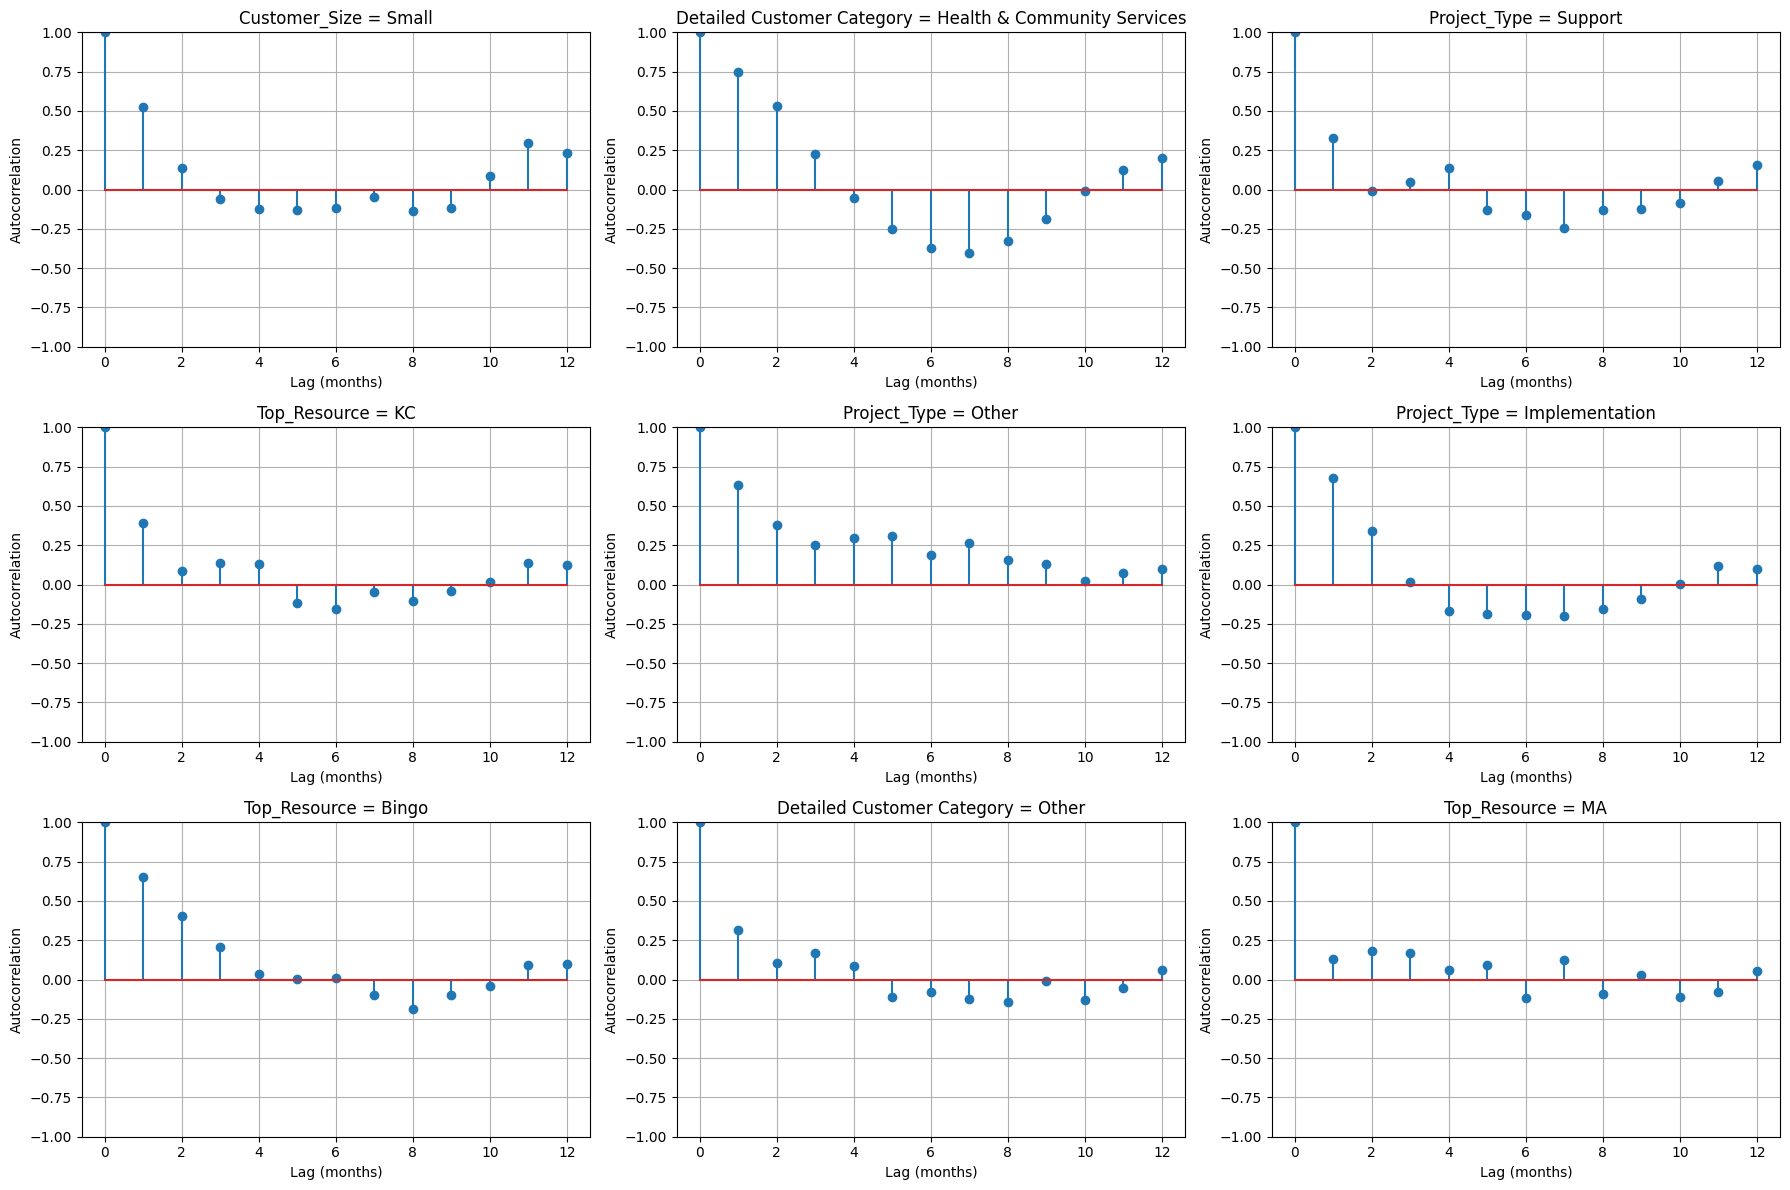

In [12]:
# Detrended ACF

top9 = seasonality_df.head(9)

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (i, row) in enumerate(top9.iterrows()):
    feature = row['Feature']
    category = row['Category']
    
    group = df[df[feature] == category]
    monthly_rev = group.groupby(pd.Grouper(key='Worked Date', freq='ME'))['Extended Price'].sum()
    
    monthly_rev_detrended = pd.Series(detrend(monthly_rev), index=monthly_rev.index)
    
    acf_vals = acf(monthly_rev_detrended, nlags=12, fft=False)
    
    # Plot on the corresponding subplot
    axes[idx].stem(range(len(acf_vals)), acf_vals)
    axes[idx].set_title(f'{feature} = {category}', fontsize=12)
    axes[idx].set_xlabel('Lag (months)')
    axes[idx].set_ylabel('Autocorrelation')
    axes[idx].set_ylim(-1, 1)
    axes[idx].grid(True)

plt.tight_layout()
plt.show()

# Seasonal Decomposition

It splits a time series into three components:

Trend – the long-term increase or decrease.

Seasonal – the repeating pattern within each period (e.g., months of a year).

Residual – what’s left over after removing trend and seasonality (noise or irregular fluctuations).

The specific decomposition you’re using is usually additive (trend + seasonal + residual = observed) or multiplicative (trend × seasonal × residual = observed), depending on how you call it.

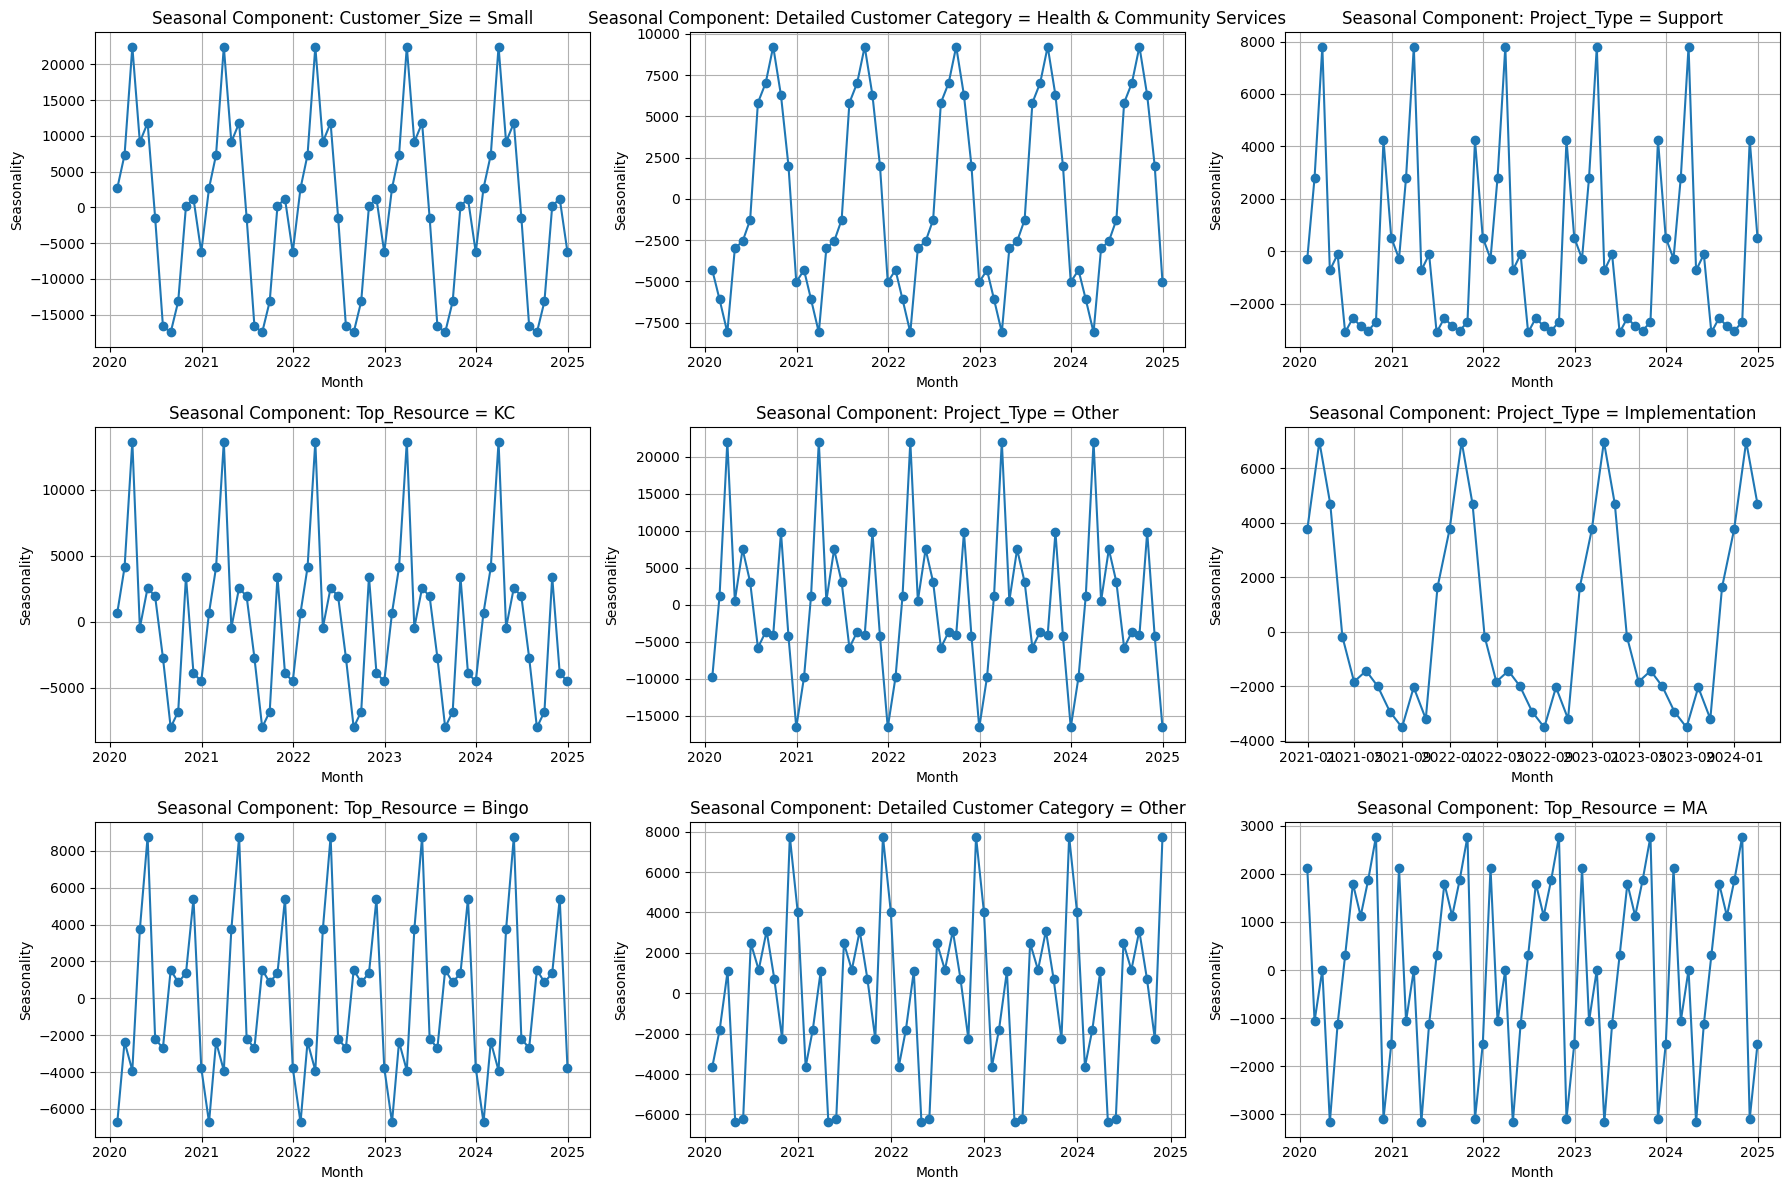

In [13]:
# Top 9 categories from your seasonality_df
top9 = seasonality_df.head(9)

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (i, row) in enumerate(top9.iterrows()):
    feature = row['Feature']
    category = row['Category']
    
    group = df[df[feature] == category]
    
    monthly_rev = group.groupby(pd.Grouper(key='Worked Date', freq='ME'))['Extended Price'].sum()
    
    decomposition = seasonal_decompose(monthly_rev, model='additive', period=12, extrapolate_trend='freq')
    
    axes[idx].plot(decomposition.seasonal, marker='o')
    axes[idx].set_title(f'Seasonal Component: {feature} = {category}', fontsize=12)
    axes[idx].set_xlabel('Month')
    axes[idx].set_ylabel('Seasonality')
    axes[idx].grid(True)

plt.tight_layout()
plt.show()


# Fourier Transformations

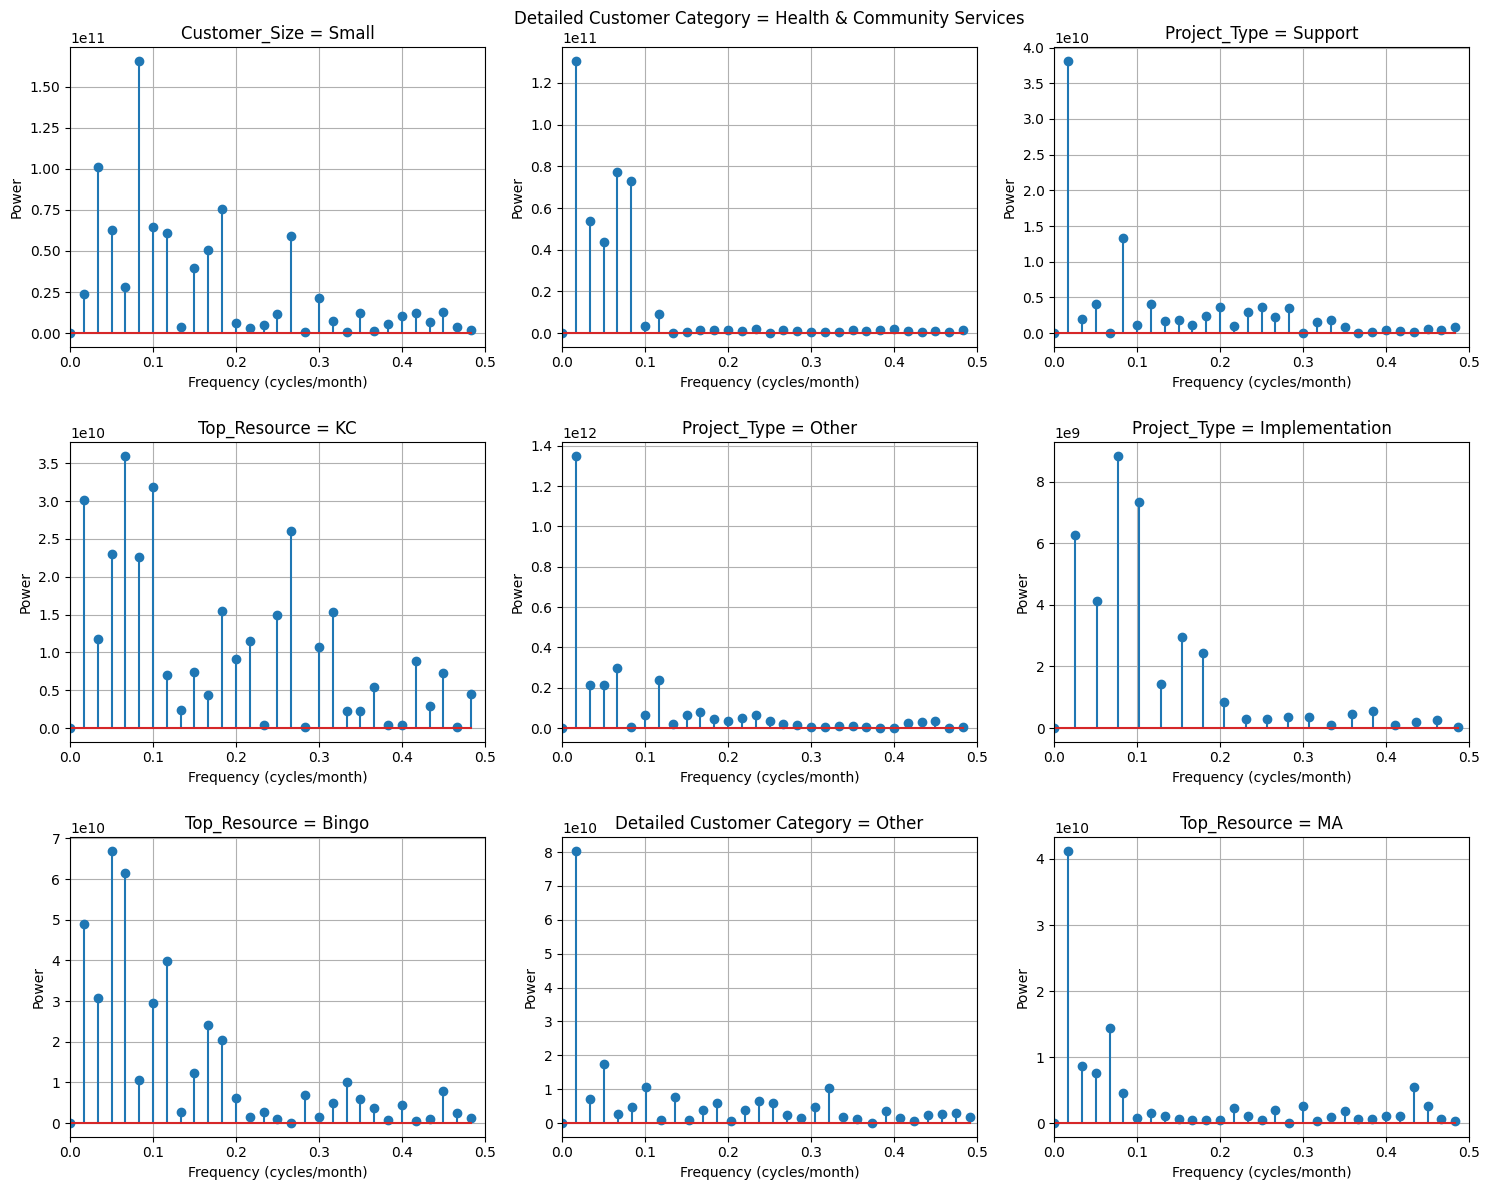

In [14]:
top9 = seasonality_df.head(9)

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, (idx, row) in enumerate(top9.iterrows()):
    feature = row['Feature']
    category = row['Category']
    
    group = df[df[feature] == category]
    
    # Aggregate monthly revenue
    monthly_rev = group.groupby(pd.Grouper(key='Worked Date', freq='ME'))['Extended Price'].sum()
    monthly_rev = monthly_rev.fillna(0)  # ensure no NaNs for FFT
    
    # Compute FFT
    fft_vals = np.fft.fft(monthly_rev - monthly_rev.mean())
    fft_freq = np.fft.fftfreq(len(monthly_rev), d=1)  # monthly spacing
    power = np.abs(fft_vals)**2
    
    axes[i].stem(fft_freq, power)  # removed use_line_collection
    axes[i].set_xlim(0, 0.5)  # focus on lower frequencies
    axes[i].set_title(f'{feature} = {category}')
    axes[i].set_xlabel('Frequency (cycles/month)')
    axes[i].set_ylabel('Power')
    axes[i].grid(True)

plt.tight_layout()
plt.show()
